In [1]:
import glob # to load general files

import Target_cohesin_loading.util_visual as utvis
from Target_cohesin_loading.funcs import *
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import gaussian_filter
from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
import Target_cohesin_loading.util_visual as utvis
from scipy import ndimage

import cooltools
import cooltools.lib.plotting
%matplotlib inline
import pandas as pd
import h5py 
import time
import sys
import ast
import chromoscores.maputils as chrmap
import chromoscores.snipping as chrsnip
import chromoscores.scorefunctions as chrscores
import warnings
import seaborn as sns

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


#### Defining required parameters

In [3]:
birth = 1
face = 1
life = 50
base_loading = 0.0001
sep = 100
window_size = 1
LatticeSize = 0.25 # in kb
rep = 1 
mon = 1000
site = 10
ba_time = 2500000
paramdict_CTCF={
            'CTCF_facestall':[face, face],
            'LEF_lifetime':[life, life],
            'LEF_birth':[base_loading, birth],
            'LEF_separation':sep
            }
total_sites = 10000
# modifying density based on new loading on target
density_multiplier = 1 + (((birth-base_loading)/base_loading)/total_sites)
paramdict_CTCF['LEF_separation'] /= density_multiplier
LEFNum = int(paramdict_CTCF['LEF_separation'])

In [4]:
path_dict = {}

directory=dire = '/scratch1/rahmanin/target_loading_cohesin/target/target_mult_sites/sims/'

for fname in glob.glob(directory+'folder*'):
    path_dict[fname.split('sims/')[1][:]]= fname
path_dict = dict(sorted(path_dict.items()))

#### calculating/visualizing ratio

relative ratio is 20.778780658715583


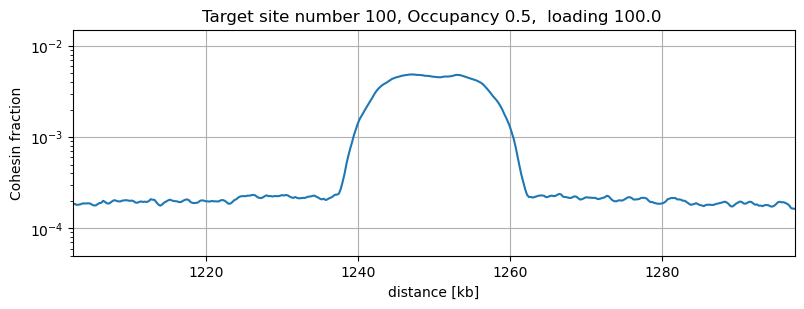

relative ratio is 1.1860410085916795


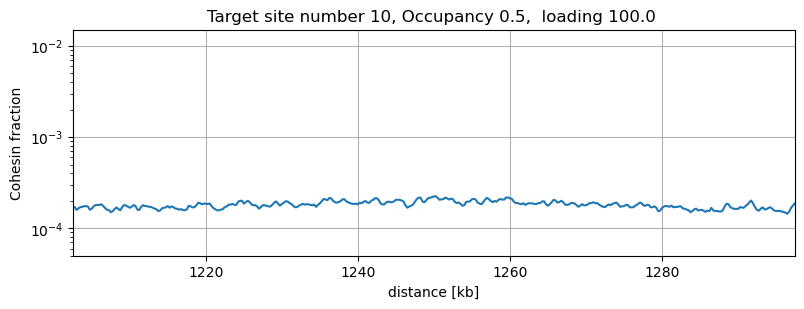

relative ratio is 1.3991815747242298


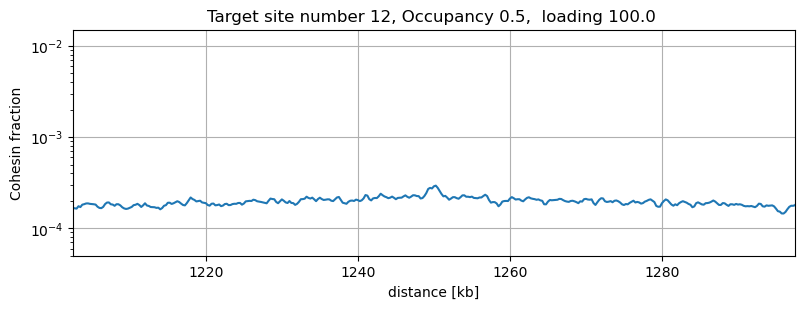

relative ratio is 2.0286333536258168


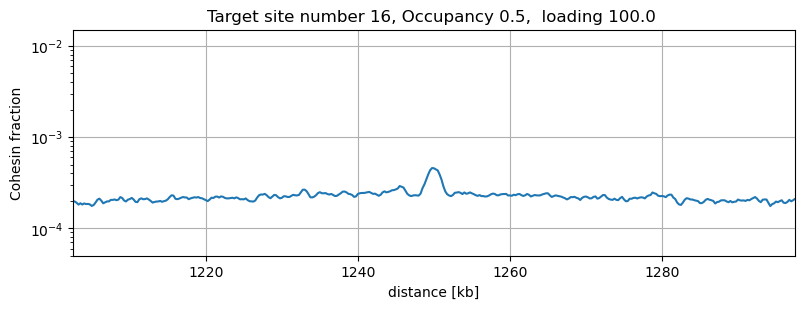

relative ratio is 0.9934505506057978


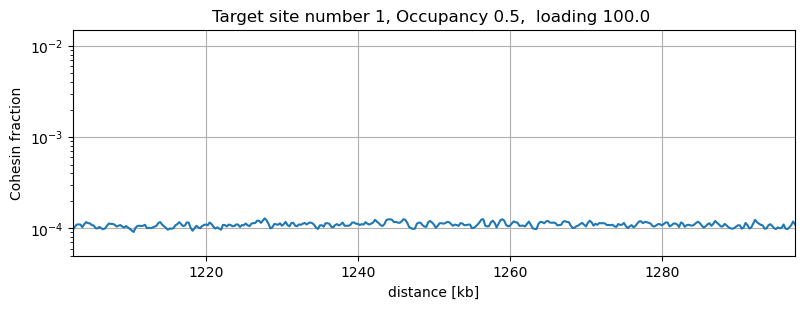

relative ratio is 2.5427684670300605


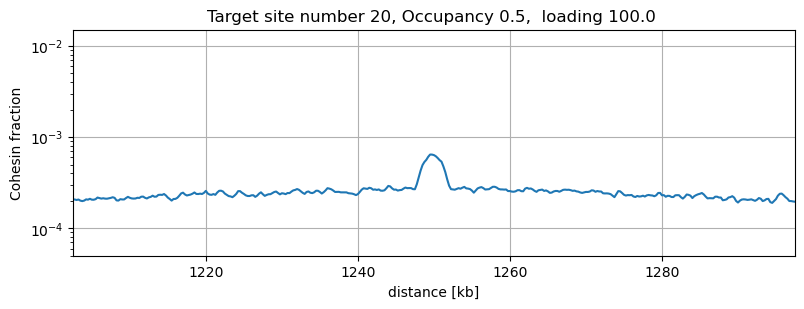

relative ratio is 3.3571498844563394


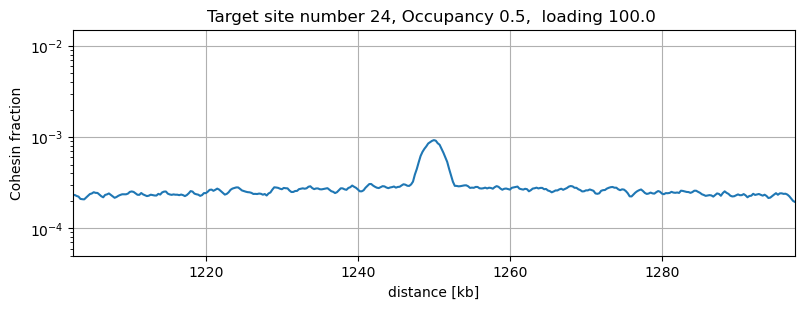

relative ratio is 1.113569827111216


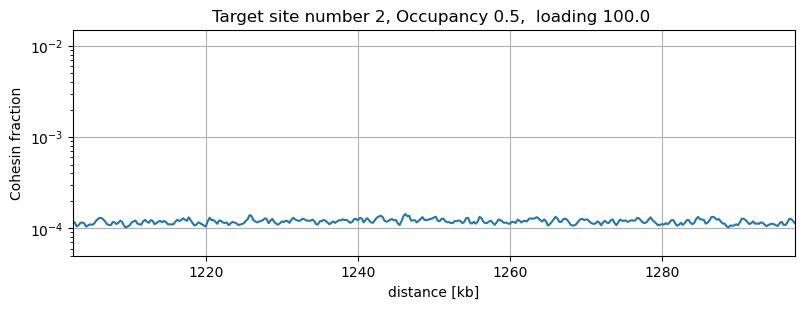

In [6]:
numx,numy = 1,len(path_dict)
hist_dict = {}
c=1
sns.reset_defaults()
file = open('data/relative_ratio_target_targetnum_res_rev_further_15kbzz.csv','w')
file.write('birth,target_s_num,deltactcf,clife,cof,sep,face,ratio\n')
dire = '/scratch1/rahmanin/target_loading_cohesin/target/target_mult_sites/sims/'
for name in list(path_dict.keys())[:80]:
    try:
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, target_s_num, deltactcf, pause, sep, site, mon, rep, step, vel = params
        if deltactcf!= 1600 or birth!= 0.01: continue
        c += 1
        mapN = mon * site
        lefs = h5py.File(dire + name + '/LEFPositions.h5','r')["positions"]
        lef_lefts = lefs[ba_time:,:,0].flatten()
        lef_rights = lefs[ba_time:,:,1].flatten()
        ctcfrightlist = np.array(h5py.File(dire + name + '/LEFPositions.h5','r')['CTCF_sites_right'])
        ctcfleftlist = np.array(h5py.File(dire + name +'/LEFPositions.h5','r')['CTCF_sites_left'])
        lst = np.array(list(ctcfrightlist))# + list(ctcfleftlist))
        lef_positions = np.hstack((lef_lefts,lef_rights))
    
        plt.figure(figsize = (8.15,3.195))
        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
    
        plt.scatter(5001, 0.0001, marker='P', color='orange', s=100)
        plt.plot(np.arange(len(a)) * 0.25, a/np.sum(a), label=name)
        ratio = (np.sum(a[4998:5002])/((np.sum(a[5080:5084])+np.sum(a[4916:4920]))/2))
        print('relative ratio is %s'%ratio)
        file.write('%s,%s,%s,%s,%s,%s,%s,%s\n'%(birth,target_s_num, deltactcf,clife,cof,sep,face,ratio))
        plt.scatter(ctcfrightlist,np.zeros(len(ctcfrightlist))+0.000095,marker='<',color='red',s=150,zorder=3)
        plt.scatter(ctcfleftlist,np.zeros(len(ctcfleftlist))+0.000095,marker='>',color='red',s=150,zorder=3)

        plt.grid(True)
        
        plt.ylim(0.00005, 0.015)
        plt.xlim(4810 * 0.25, 5190 * 0.25)
        hist_dict[name] = a/np.sum(a)
    
        plt.ylabel('Cohesin fraction')
        plt.yscale('log')
        plt.xlabel('distance [kb]')
        plt.title(r'Target site number %s, Occupancy 0.5,  loading %s '%(target_s_num, np.round(birth/base_loading)))
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass
        
file.close()

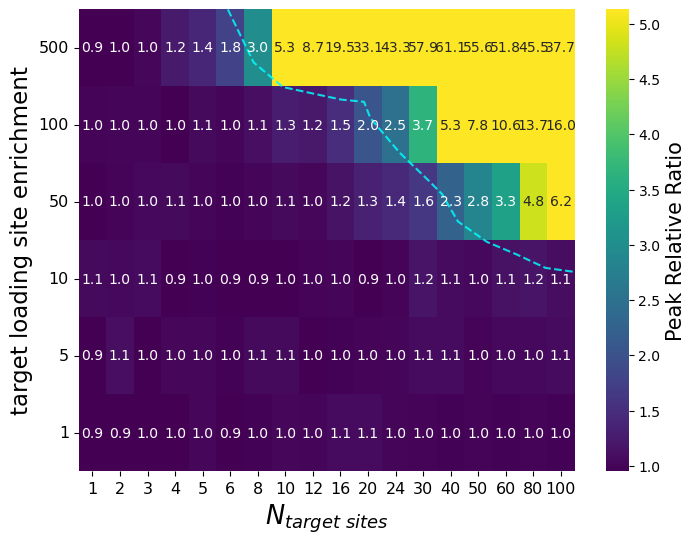

In [6]:
file = pd.read_csv('data/relative_ratio_target_targetnum_res_rev_further.csv') 

file['birthp']=(file['birth']/base_loading).astype(int)
file['deltactcf']=file['deltactcf']*LatticeSize/2
deltactcf = file['deltactcf']
file = file[file['birthp']<1000]
unique_birth=np.unique(birth)
unique_deltactcf = np.unique(deltactcf)
clife = np.unique(file['clife'])[0]
for deltactcf in np.unique(file['deltactcf']):
    for cof_val in np.unique(file['cof']):
        for sep_vals in [ 74]:
            new_file = file[file['deltactcf']==deltactcf]
            new_file = new_file[new_file['sep']==sep_vals]    
            new_file = new_file[new_file['cof']==cof_val]
            new_file['ratio']=new_file['ratio'].round(3)
           
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            
            dtaframe_grouped = new_file_filtered.groupby(['birthp', 'target_s_num'], as_index=False).mean()
            
            heatmap_data = dtaframe_grouped.pivot('birthp', 'target_s_num', 'ratio')
            # Create the heatmap using seaborn
            plt.figure(figsize=(8, 6))
            im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='1.1f',vmin=0.95,vmax=5.131, cbar_kws={'label': 'Frip score'} )
            sns.set(font_scale=0.81)
            cbar = im.collections[0].colorbar
            cbar.set_label('Peak Relative Ratio', fontsize=15)
            ##### making equepotentiala
            val = 1.8
            cline_num=18
            coline_num=6
            smooth_scale = 1
            d = gaussian_filter(heatmap_data.to_numpy(), sigma=0.15)
            
            z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)

            cntr1 = im.contour(np.linspace(0, cline_num, cline_num * smooth_scale),
                           np.linspace(0, coline_num, coline_num * smooth_scale),
                           d, levels=[1.91], colors='cyan', linestyles='dashed', alpha=0.83)
        
            # Add legend manually for the contours
            plt.xlabel(r'$N_{target\ sites}$', fontsize = 18.5)
            plt.xticks(fontsize =11.5)
            #plt.title(r'proc=%s kb, $\delta_{ctcf, target}$=%s kb, $\tau_b$/$\tau_E$=%s, Occup = %s, density= 1/%s kb'%(life*5, 250, np.round(clife/life,1),np.round(clife/(clife+cof_val),1), sep_vals*2.5), fontsize = 11)
            plt.ylabel(r'target loading site enrichment', fontsize =16.5)
            plt.yticks(fontsize=11.5, rotation=0)
            plt.gca().invert_yaxis()
            plt.savefig('figs/heatmap.pdf')
            plt.show()

In [5]:
#The Md simualtions HiC maps

In [5]:
path_dict = {}

directory = './mapsnew'

for name  in glob.glob(directory+'/folder_*'):
    path_dict[name.split('/mapsnew/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))
print(len(path_dict))

121


In [6]:
import matplotlib as mpl

# Reset to defaults
mpl.rcdefaults()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


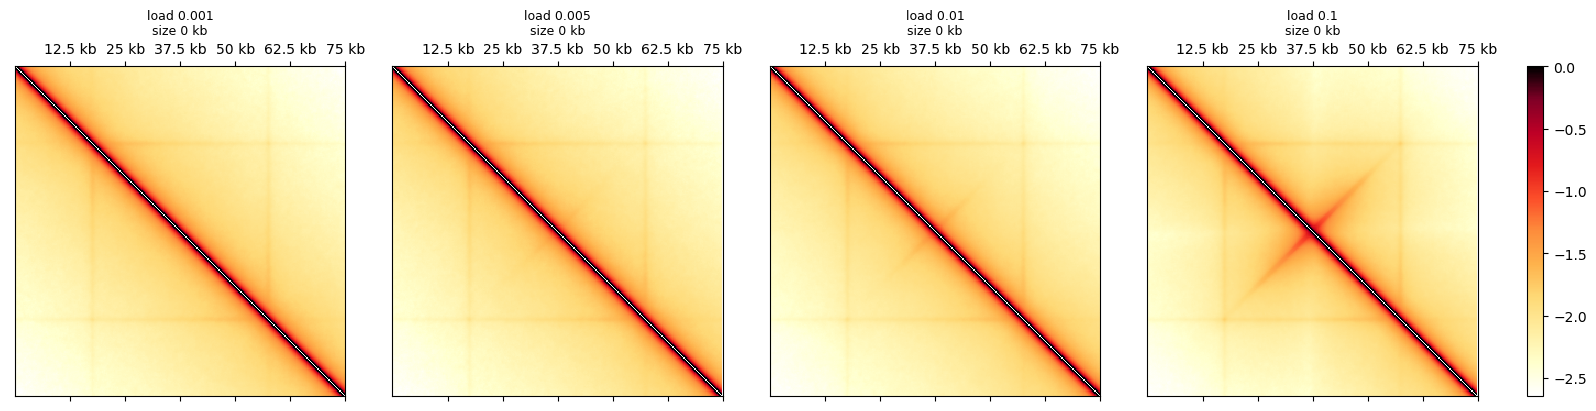

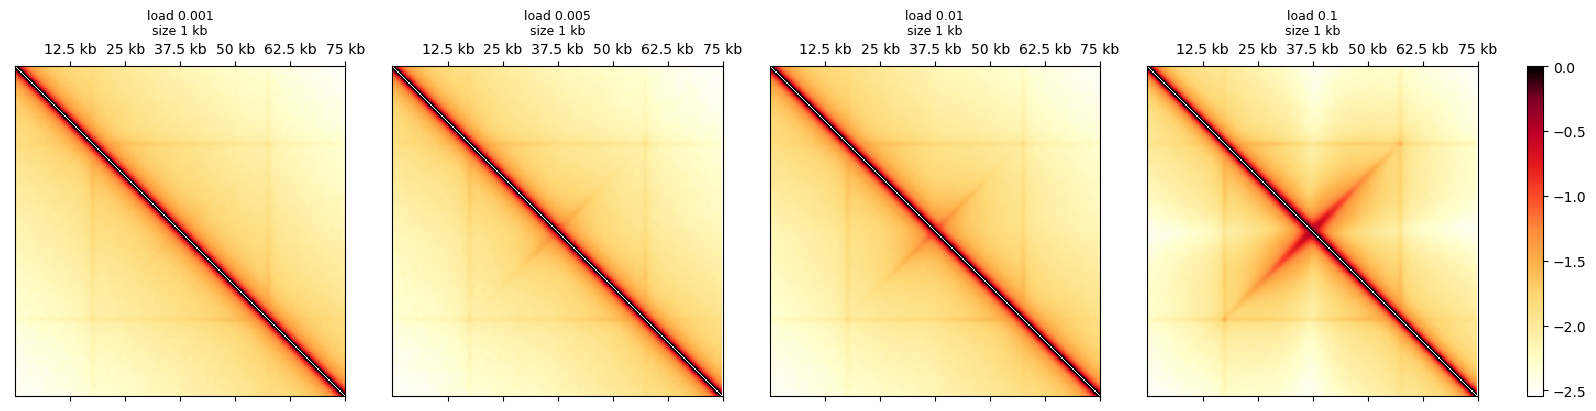

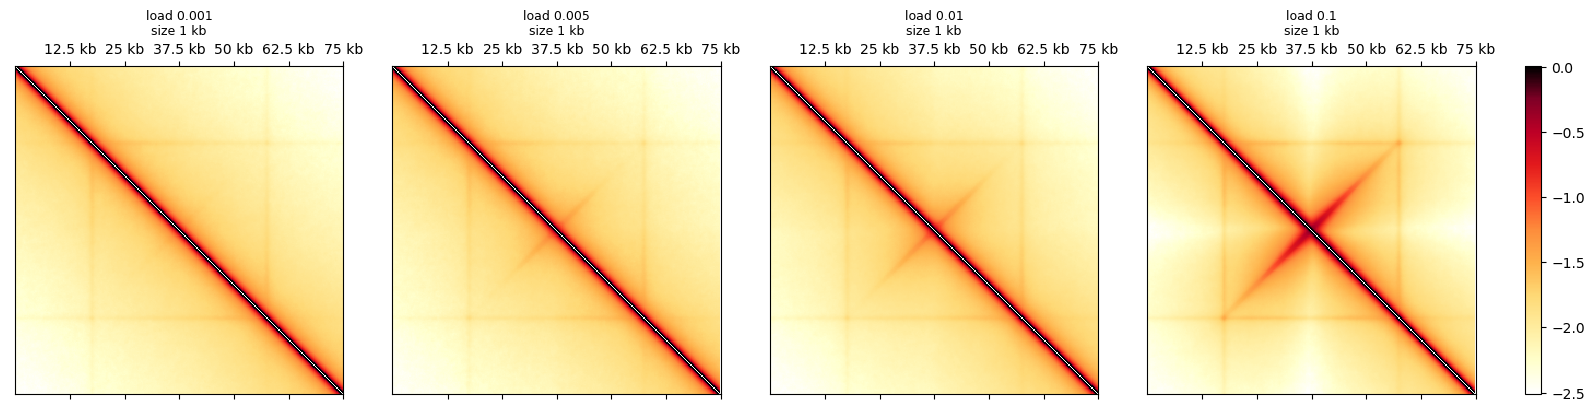

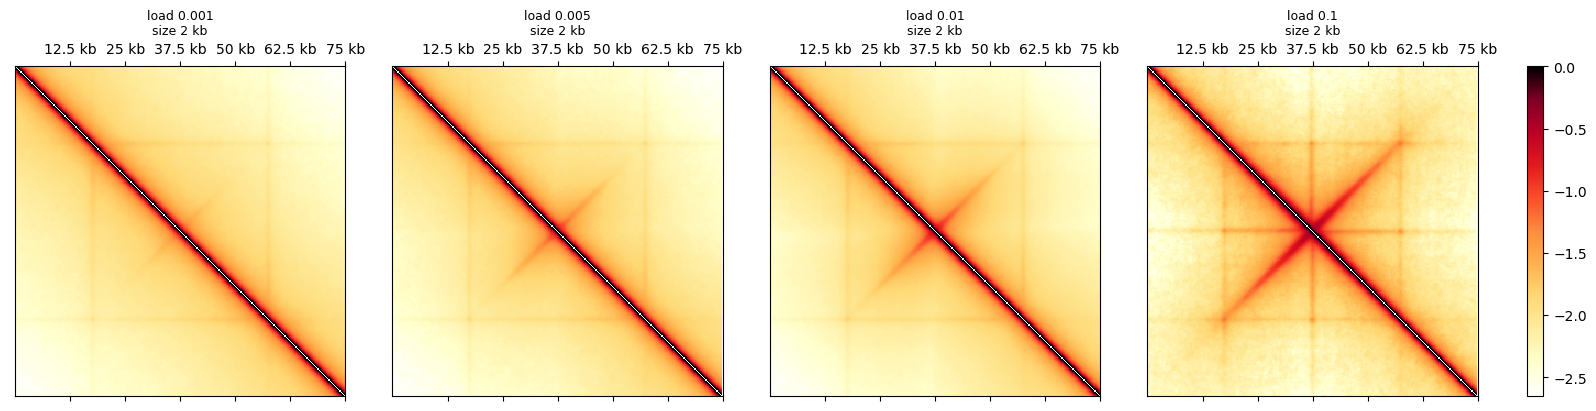

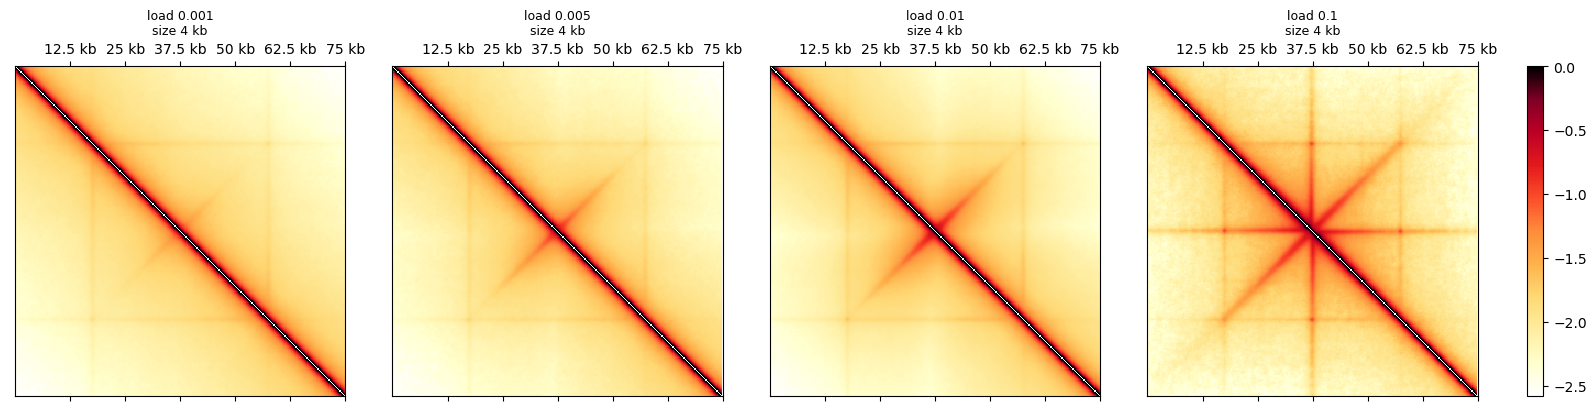

In [13]:
# define specific sizes and rates
target_list = [1, 3, 4, 10, 16]
birth_list = [0.001, 0.005, 0.01, 0.1]

for tnum in target_list:
    selected_names = []
    for name in path_dict.keys():
        params = [ast.literal_eval(i) for i in name.split('npz')[0]
                  .split('folder_')[1].split('_')[1::2]]
        _, _, _, _, life, _, birth, targetnum, deltactcf, _, sep, _, _, _, _, _ = params

        if (life == 66 and sep == 74 and deltactcf == 1600
            and targetnum == tnum and any(abs(birth - b) < 1e-8 for b in birth_list)):
            selected_names.append(name)

    if not selected_names:
        continue

    # same plotting setup as your original
    fig, axes = plt.subplots(
        1, len(selected_names),
        figsize=(4 * len(selected_names), 4),
        constrained_layout=True
    )
    if len(selected_names) == 1:
        axes = [axes]

    im = None
    for ax, name in zip(axes, selected_names):
        params = [ast.literal_eval(i) for i in name.split('npz')[0]
                  .split('folder_')[1].split('_')[1::2]]
        _, _, _, _, life, _, birth, targetnum, deltactcf, _, sep, _, _, _, _, _ = params

        data = np.load('%s' % path_dict[name])
        mrc = data['arr_0'].astype(float)
        mrc /= np.median(np.diag(mrc, 2))
        # mat = chrmap.get_observed_over_expected(mrc)
        mat = mrc

        im = ax.matshow(np.log10(mat[350:650, 350:650]), cmap='fall', rasterized=True)

        # axis tick conversion and label formatting
        ax.set_xticks([50, 100, 150, 200, 250, 300])
        ax.set_xticklabels(['12.5 kb', '25 kb', '37.5 kb', '50 kb', '62.5 kb', '75 kb'], fontsize=10.1)
        ax.set_yticks([])
        ax.set_yticklabels([], fontsize=8.1)
        ax.set_title(f'load {birth:.3g}\nsize {targetnum/4:.0f} kb', fontsize=9)

    # shared colorbar
    fig.colorbar(im, ax=axes, fraction=0.025, pad=0.02)

    # save figure
    fig.savefig(
        f'figs/maps_observed_expected/fountain_target_{tnum}.png',
        dpi=500,
        bbox_inches='tight',
        pad_inches=0.15
    )
    plt.show()
    plt.close(fig)


In [14]:
#### Observed over expected

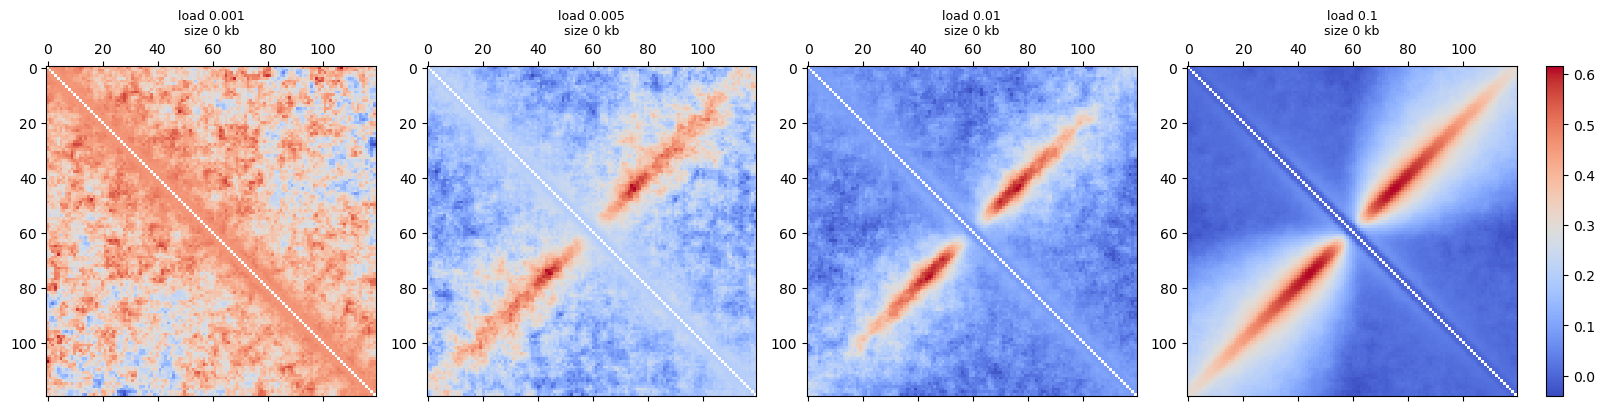

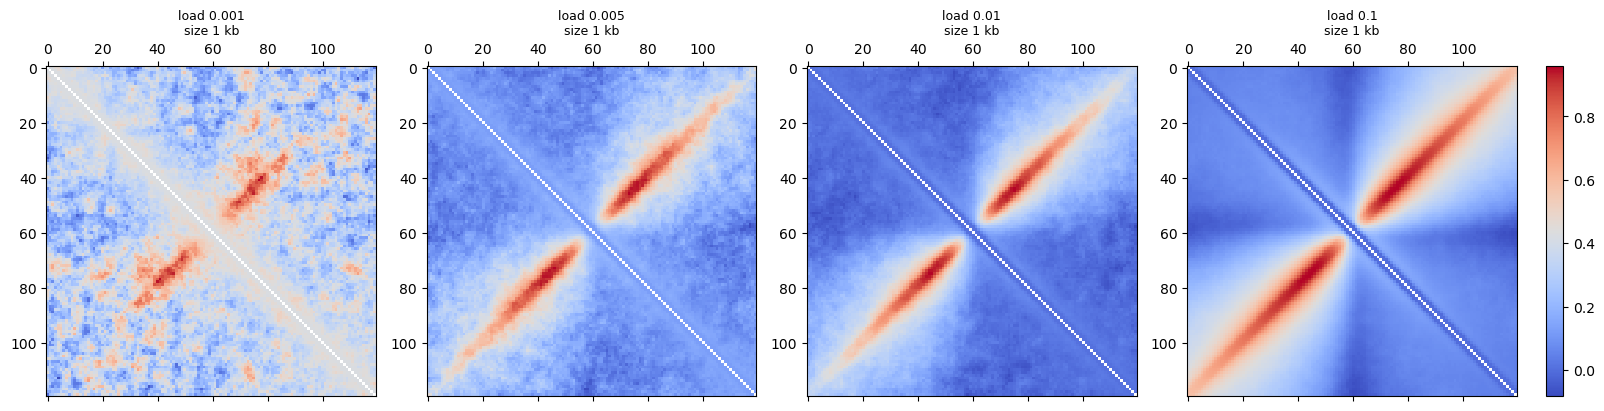

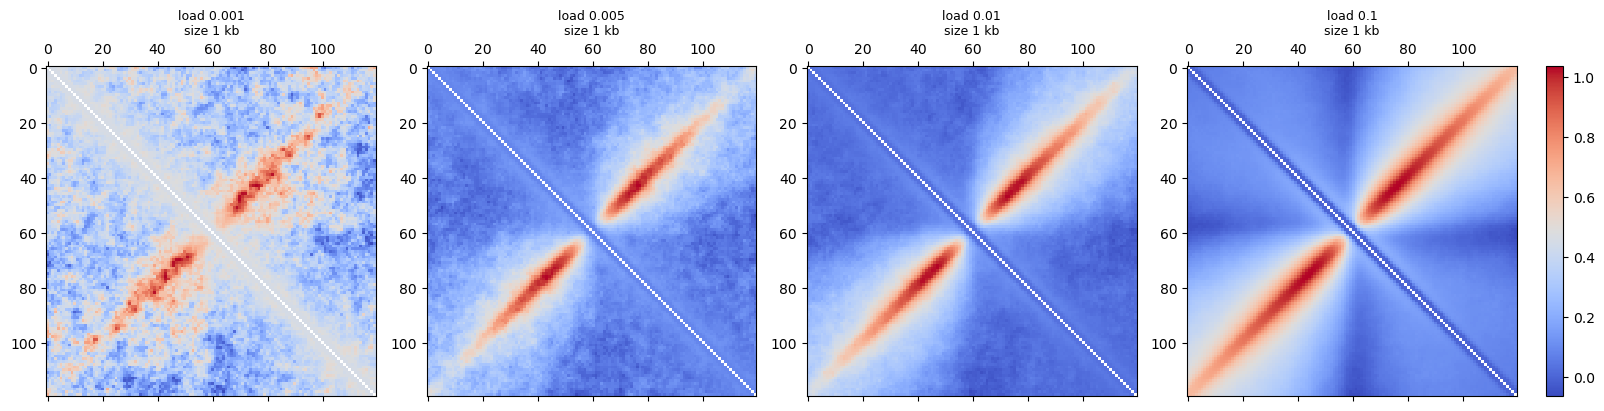

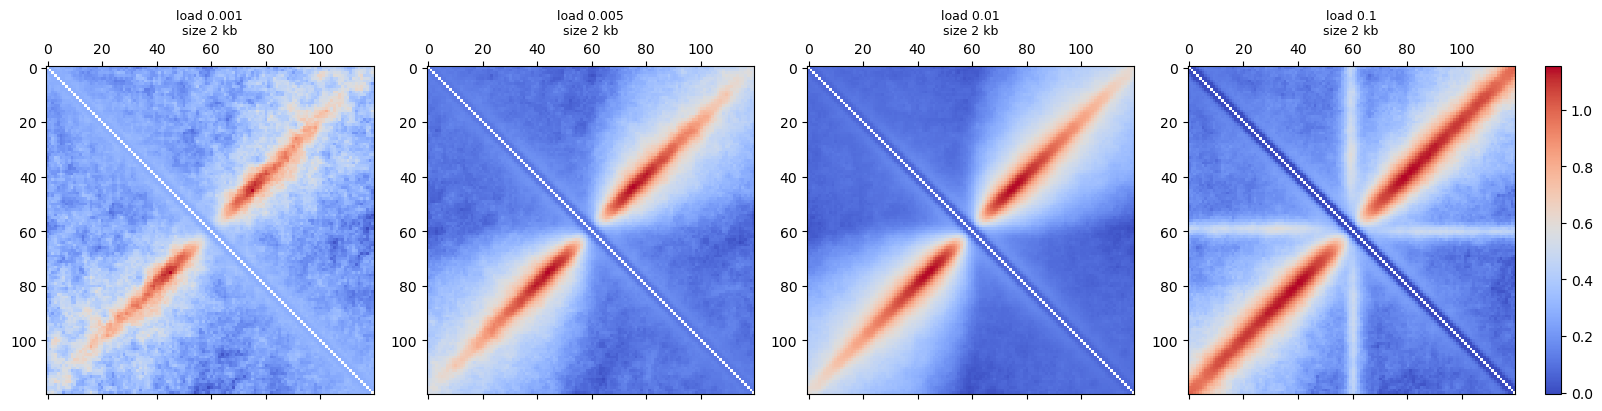

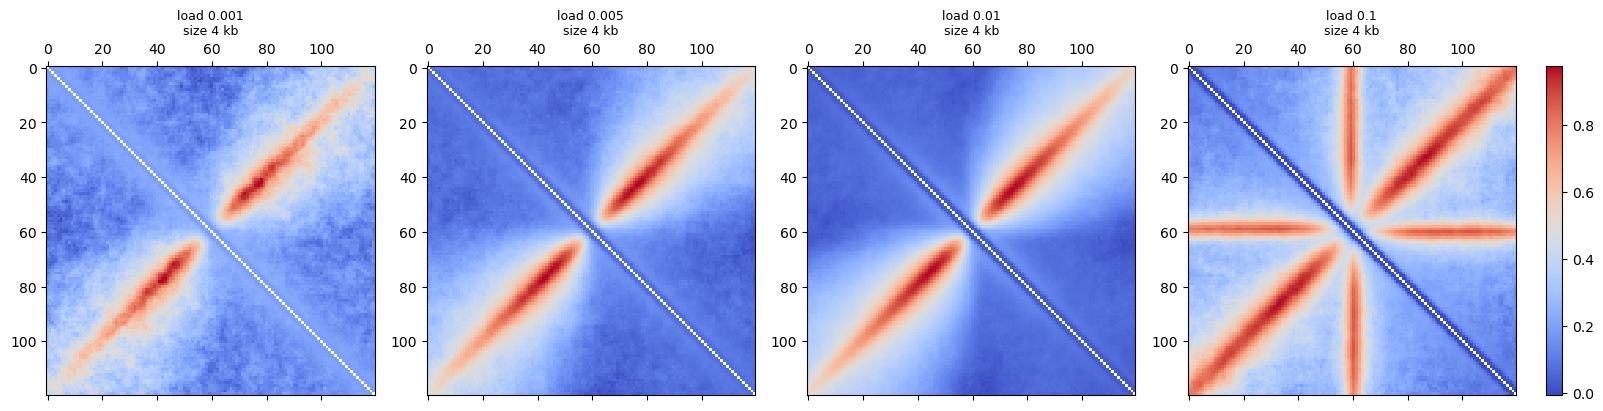

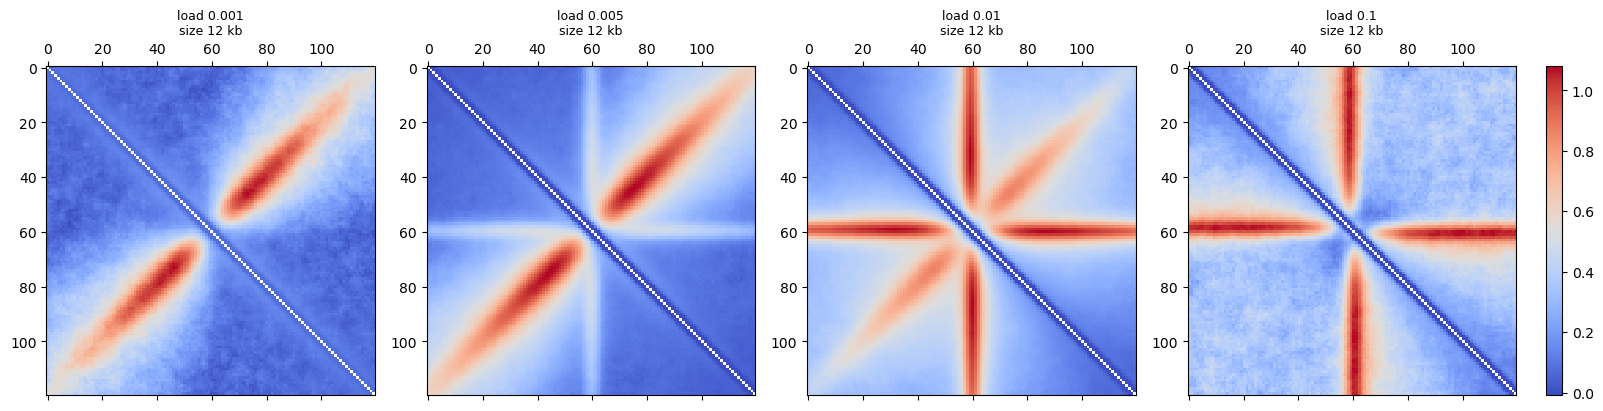

In [9]:
# define specific sizes and rates
target_list = [1, 3, 4, 10, 16,50 ]

birth_list = [0.001, 0.005, 0.01, 0.1]

for tnum in target_list:
    selected_names = []
    for name in path_dict.keys():
        params = [ast.literal_eval(i) for i in name.split('npz')[0]
                  .split('folder_')[1].split('_')[1::2]]
        _, _, _, _, life, _, birth, targetnum, deltactcf, _, sep, _, _, _, _, _ = params

        if (life == 66 and sep == 74 and deltactcf == 1600
            and targetnum == tnum and any(abs(birth - b) < 1e-8 for b in birth_list)):
            selected_names.append(name)

    if not selected_names:
        continue

    # same plotting setup as your original
    fig, axes = plt.subplots(
        1, len(selected_names),
        figsize=(4 * len(selected_names), 4),
        constrained_layout=True
    )
    if len(selected_names) == 1:
        axes = [axes]

    im = None
    for ax, name in zip(axes, selected_names):
        params = [ast.literal_eval(i) for i in name.split('npz')[0]
                  .split('folder_')[1].split('_')[1::2]]
        _, _, _, _, life, _, birth, targetnum, deltactcf, _, sep, _, _, _, _, _ = params

        data = np.load('%s' % path_dict[name])
        mrc = data['arr_0'].astype(float)
        mrc /= np.median(np.diag(mrc, 2))
        mat = chrmap.get_observed_over_expected(mrc)

        im = ax.matshow(np.log10(mat[440:560, 440:560]), cmap='coolwarm', rasterized=True)
        ax.set_title(f'load {birth:.3g}\nsize {targetnum/4:.0f} kb', fontsize=9)

    # shared colorbar
    fig.colorbar(im, ax=axes, fraction=0.025, pad=0.02)

    # save figure
    fig.savefig(
        f'figs/maps_observed_expected/fountain_target_{tnum}.png',
        dpi=500,
        bbox_inches='tight',
        pad_inches=0.15
    )
    plt.show()
    plt.close(fig)
